# Data Lab 9

Skill scores for probability forecasts. 
- Brier
- Reliability
- Log score

Nino 3.4 forecasts from the North American Multimodel ensemble.

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

## 1. Skill scores 

### 1.1 Deterministic (format of the forecast, single number forecast)

#### 1.1.1 Anomaly correlation

Forecasts $f_1, ..., f_n$ with mean $\overline{f}$.  
Observations $o_1, ..., o_n$ with mean $\overline{o}$.


$$ \text{AC} = \frac{\hat{\sigma}_{fo}}{\hat{\sigma}_f \hat{\sigma}_o} = 
\frac{\displaystyle \sum_{n=1}^N (f_n - \overline{f}) (o_n - \overline{o})}{\displaystyle\sqrt{\sum_{n=1}^N (f_n - \overline{f}) ^2}\sqrt{\sum_{n=1}^N (o_n - \overline{o})^2}} $$

#### 1.1.2 MSE
Smaller values are better. Never negative.

Forecasts $f_1, ..., f_n$.
Observations $o_1, ..., o_n$.

$$ \text{MSE} = \frac{1}{N} \sum_{n=1}^N (f_n - o_n)^2 $$

#### 1.1.3 MSE skill score (MSESS)

Best value is 1.  
Zero means the same MSE as the reference forecast.  
Negative means worse than the reference forecast.  
Typical reference is the mean $\overline{o}$.

Forecasts $f_1, ..., f_n$.  
Observations $o_1, ..., o_n$.

$$ \text{MSESS} = 1 - \frac{\text{MSE}}{\text{MSE}_\text{ref}} = 1 - \frac{\displaystyle\sum_{n=1}^N (f_n - o_n)^2}{\displaystyle\sum_{n=1}^N (o_n - \overline{o})^2}  = 1 - \frac{\text{MSE}}{\hat{\sigma}_o^2}$$

For this reference forecast $\overline{o}$, the decompostion of MSESS is

$$ \text{MSESS} = \text{AC}^2 - \left( \frac{\hat{\sigma}_f}{\hat{\sigma}_o} - \text{AC}\right)^2 - \frac{(\overline{f} - \overline{o})^2}{\hat{\sigma}_o^2} $$

$$ \text{MSESS} = \text{Frac. explained var.} - \text{Cond. bias}^2 - \text{Bias}^2 $$

### 1.2 Probabilistic forecasts

Random variable $O$ which is one if the event occurs, and zero if it does not. 

The forecast probablity $F$ is the forecaster's estimate of the likelihood of the event.

#### Example: Joint-normal (aka linear regression) model

$y$ something observed, e.g., rainfall.

$x$ something informative, e.g., Nino 3.4

$$ y = x \beta + \epsilon\,, \qquad \epsilon \sim N(0, \sigma_{\epsilon}^2)$$

Recall that

$$ p(y|x) = N(\beta x, \sigma_{\epsilon}^2) $$

Define our event $O$ to be $O = y > 0.5$. The

$$ p(O | x) = P( y>0.5 | x) = 1 - \Phi\left(\frac{0.5 - \beta x}{\sigma_{\epsilon}} \right) $$
where $\Phi$ is the cdf of $N(0,1)$.

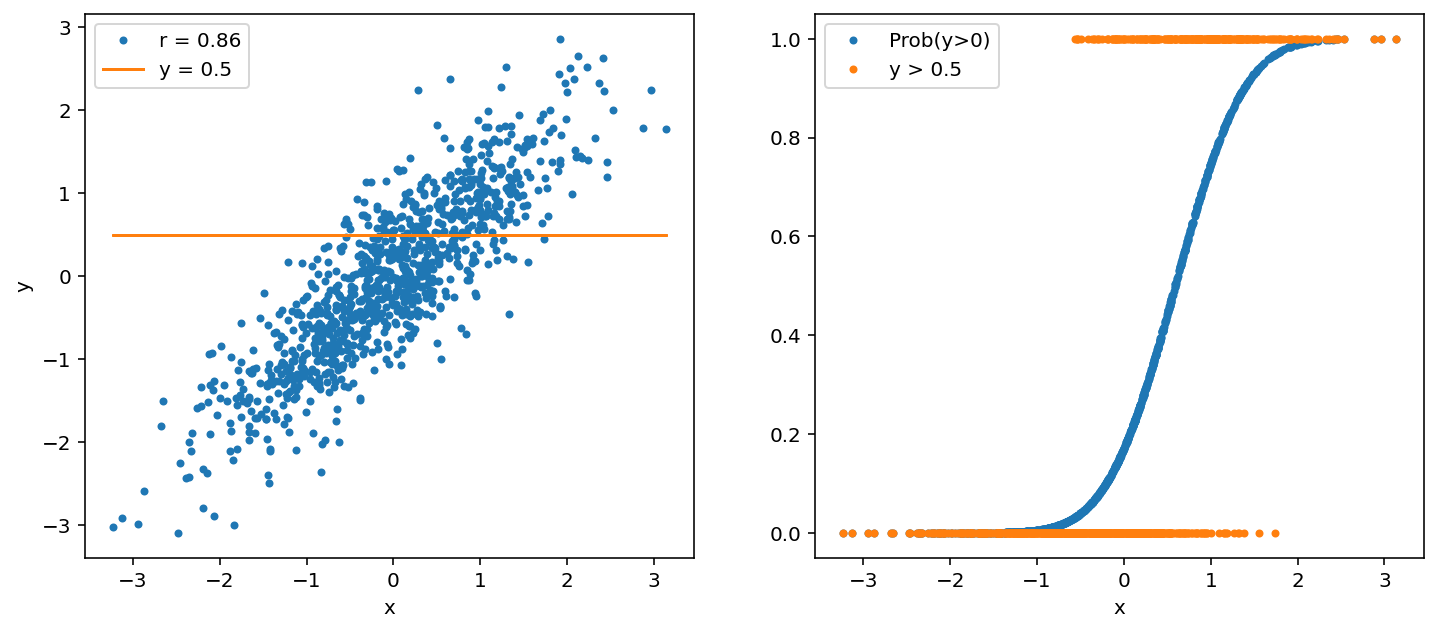

In [3]:
from scipy import stats

N = 1000 #number of forecasts
beta = 0.85
sigma_e = np.sqrt(1 - beta**2)

# x's for different forecasts 
x = np.random.normal(size = N)
epsilon = sigma_e*np.random.normal(size = N)
y = beta*x + epsilon
O = y > 0.5;

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
label = 'r = {:2.2f}'.format(cor(x,y))
axs[0].plot(x, y, '.', label = label)
axs[0].plot(x, y*0 + 0.5, label = 'y = 0.5')
axs[0].legend();
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# forecast of y > 0.5
F = 1 - stats.norm.cdf((0.5 - beta*x)/sigma_e)
axs[1].plot(x, F, '.', label = 'Prob(y>0)')
axs[1].plot(x, O, '.', label = 'y > 0.5')
axs[1].set_xlabel('x')
axs[1].legend();

#### 1.2.1 Reliability

$$ E[O | F] = F ? $$

Does the observed occurrence frequency match the forecast probability?

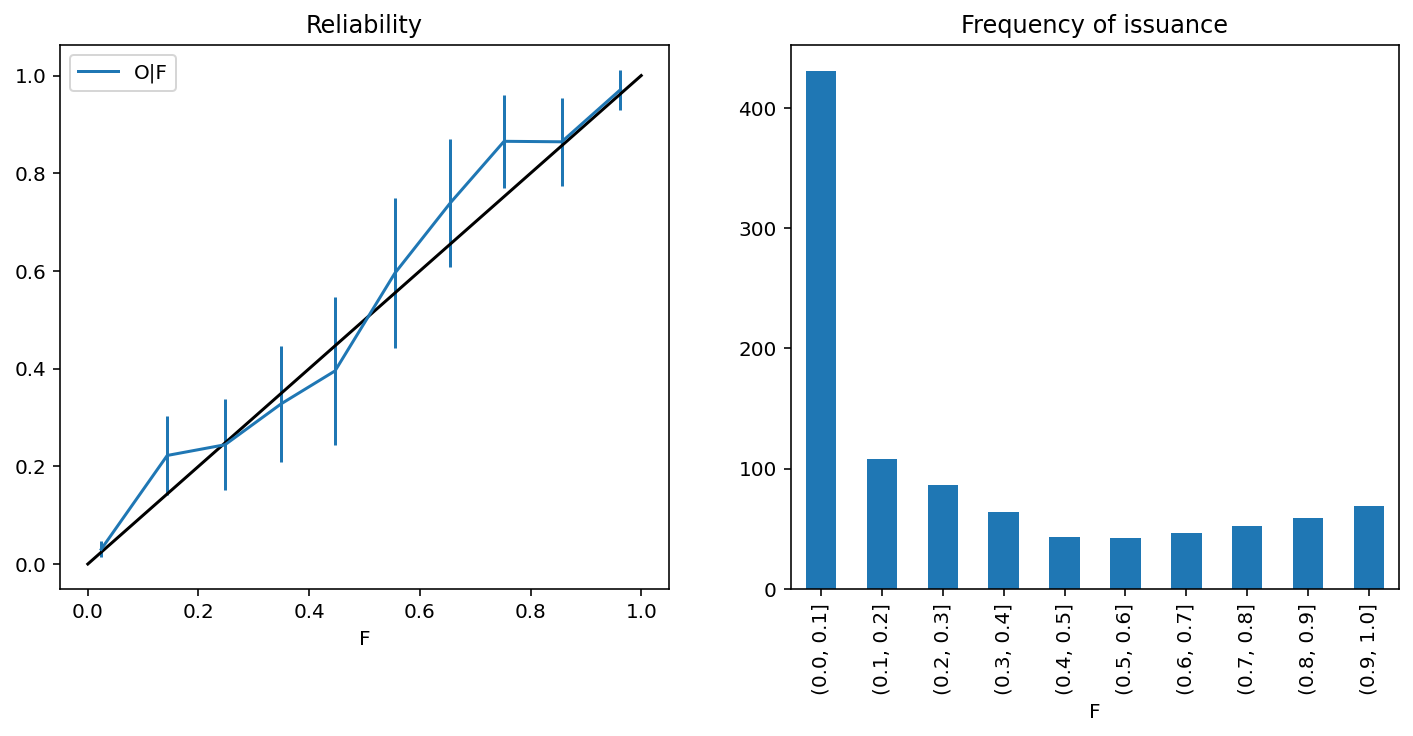

In [4]:
import pandas as pd

df = pd.DataFrame()
df['F'] = F
df['O|F'] = O
df

fbins = pd.cut(df.F, np.linspace(0., 1., 11))

OcondF = df.groupby(fbins).mean()
yerr = 2*df.groupby(fbins).std()/np.sqrt(df.groupby(fbins).count())

fig, axs = plt.subplots(1, 2, figsize = (12, 5))

ax = axs[0]
OcondF.plot(x = 'F', yerr = yerr, ax = ax);
ax.plot((0, 1), color = 'k')
ax.set_title('Reliability');

ax = axs[1]
df['F'].groupby(fbins).count().plot(x = 'F', kind = 'bar')
ax.set_title('Frequency of issuance');

#### 1.2.2 Brier score

Reliability is not enough. Why?

Desirable qualities of a probability forecast are:  
1. Reliability
2. Not just the base rate = sharpness, resolution

A climatological forecast (base rate) forecast is reliable but obvious.

Which brings us to the Brier (quadratic) score.

Smaller values are better. Never negative.

Probability forecasts of the event $F_1, ..., F_n$.
Occurrence of the event $O_1, ..., O_n$.

$$ \text{Brier Score} = \frac{1}{N} \sum_{n=1}^N (F_n - O_n)^2 $$

The Brier score is squared error in probabilities.

Decomposition of the Brier score.

Suppose we have:

Probability forecasts of the event $F_1, ..., F_n$.
Occurrence of the event $O_1, ..., O_n$.

and we
1. Bin the forecast probabilities to make a reliability diagram. 
2. Denote by $F^*_k$ the occurrence frequency in bin $k$
3. Denote by $\overline{O}$ the base rate
4. Denote by $B(F)$ the Brier score of $F_1, ..., F_n$

Trivially,

$$ B(F) = \left[ B(F) - B(F^*) \right] - \left[ B(\overline{O}) - B(F^*) \right] + B(\overline{O})$$

$B(F) - B(F^*)$ = reliability component

$B(\overline{O}) - B(F^*)$ = resolution component

$B(\overline{O})$ = uncertainty component


#### 1.2.3 Brier skill score

Analogous to MSESS. Values near one are good. 

Negative values mean the Brier score is less than that of the reference forecast.

$$ \text{BSS} = 1 - \frac{\text{Brier score}}{\text{Brier score reference forecast}} $$

A typical (no-skill) reference forecast is the base rate $\overline{O}$. 

For tercile-based forecasts, the base rate is 1/3 because that is how often the observation falls in the tercile category.


$$ \text{BSS} = -
\frac{B(F) - B(F^*)}{B(\overline{O})} + \frac{B(\overline{O}) - B(F^*)}{B(\overline{O})}$$

Reliability and resolution

#### 1.2.4 Ranked probability score

Speaking of tercile forecasts, how do we score forecasts of more than one category?

If the categories are ordered, (e.g., B, N, A) it make sense to define cumlative probabilities.

In that case, we can use RPS which is the squared difference of the cumlative forecast probabilities and occurrences.

Cumulative probabilities are defined as follows. Suppose that $O_B$, $O_N$, and $O_A$ are the random variables for the occurrence of below-normal, normal, and above-normal rainfall at a location. They are discrete random variables. Suppose that $F_B$, $F_N$, and $F_A$ are the corresponding forecast probabilities, which sum to one.

The cumulative event variables are: $O_B$, and $O_B + O_N$.  
The cumulative forecast probabilities are are: $F_B$, and $F_B + F_N$.  

In this case, the squared difference of the cumulative probabilities and occurrences is

$$ \text{RPS} = \frac{1}{K} \sum_{k=1}^K (O_{B,n} - F_{B,k})^2 + (O_{B,k} + O_{N,k} - F_{B,k} - F_{B,k})^2 $$

The Brier score is a proper score. A proper score is one where the best values are obtained for the true probabilities. A proper score cannot be "gamed" i.e., improved by tricky business.

The log score is another proper score.

# Exercises

## 1. (10 points) Plot something from the data you will use in your project. 
- Not data that we're used in class unless that is the only data that you will be using in your project.

## 2. (10 points) Generating joint-normal data with specified correlation.

For $|\beta| < 1$, $X \sim N(0, \sigma^2_X)$, $W \sim N(0, (1 - \beta^2) \sigma_X^2$, and 

$$ Y = X \beta + W \,, \qquad $$

show that $\text{cor}[X, Y] = \beta$.

## 3. (10 points) Use the code below for probability forecasts and events.
- Compute the Brier score and the Brier skill score
- Change the forecast so that forecast probabilities are slightly overconfident (slope in reliability diagram less than one).

In [8]:
np.random.seed(42)

from scipy import stats

N = 2000 #number of forecasts
beta = 0.7
sigma_e = np.sqrt(1 - beta**2)

# x's for different forecasts 
x = np.random.normal(size = N)
epsilon = sigma_e*np.random.normal(size = N)
y = beta*x + epsilon

#Event
O = y > 0.5;

#Forecast
F = 1 - stats.norm.cdf((0.5 - beta*x)/sigma_e)

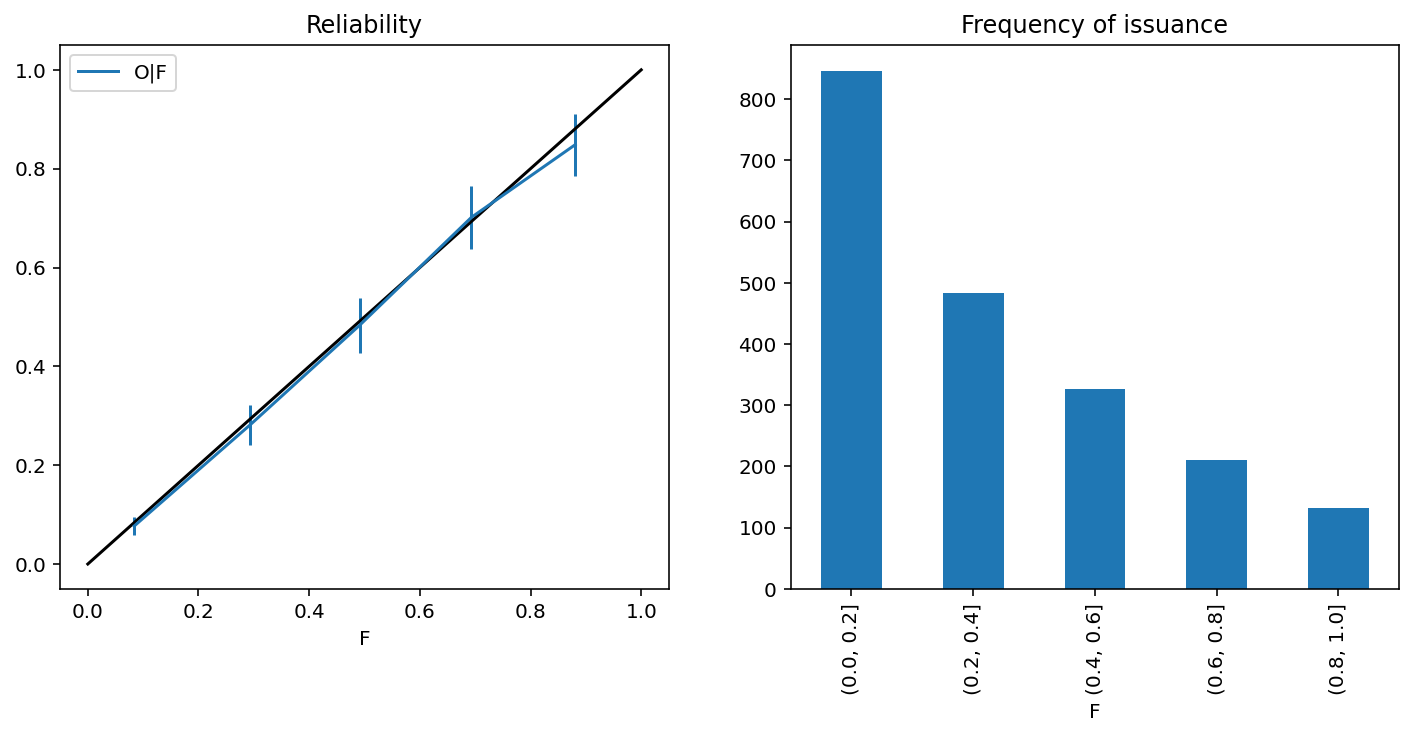

In [9]:
import pandas as pd

df = pd.DataFrame()
df['F'] = F
df['O|F'] = O

fbins = pd.cut(df.F, np.linspace(0., 1., 6))

OcondF = df.groupby(fbins).mean()
yerr = 2*df.groupby(fbins).std()/np.sqrt(df.groupby(fbins).count())

fig, axs = plt.subplots(1, 2, figsize = (12, 5))

ax = axs[0]
OcondF.plot(x = 'F', yerr = yerr, ax = ax);
ax.plot((0, 1), color = 'k')
ax.set_title('Reliability');

ax = axs[1]
df['F'].groupby(fbins).count().plot(x = 'F', kind = 'bar')
ax.set_title('Frequency of issuance');

## 3. (10 points) For a single forecast, the forecast probability $F$ is given and the corresponding observation $O$ is a discrete random variable. 

Assume the forecast is reliable.
- What is the value of $E[O]$?
- What is the expected Brier score of the forecast?

## 4. (10 points) Show the RPS of a 3-category forecast is sum of the Brier scores of the Below and Above categories.

$$ \text{RPS} = \text{Brier score(Below)} + \text{Brier score(Above)} $$